In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import logging
import itertools
import random
import warnings
import time
import os
import datetime as dt
import plotly.express as px
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras_preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
# Setting some options for general use.


sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

In [32]:
# dataset for model training
model_data = pd.read_csv('news_articles.csv')


In [33]:
model_data.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [34]:
## picking the relevant columns
model_data = model_data[['text_without_stopwords', 'label']]
model_data

,text_without_stopwords,label
0,print pay back money plus interest entire fami...,Real
1,attorney general loretta lynch plead fifth bar...,Real
2,red state fox news sunday reported morning ant...,Real
3,email kayla mueller prisoner tortured isis cha...,Real
4,email healthcare reform make america great sin...,Real
...,...,...
2091,NaN,Real
2092,NaN,Real
2093,NaN,Fake
2094,NaN,Fake


In [38]:
## specifying the clean text as  string
model_data.text_without_stopwords=model_data.text_without_stopwords.astype(str)

In [39]:
## to silence warning
os.environ["WANDB_API_KEY"] = "0"

In [40]:
## using the TPU in trainig
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [41]:
## dealing with randomness in results
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

________________

In [42]:
## splitting to get the development data
train, test = train_test_split(model_data, test_size = 0.20, random_state = 1)
x_train, dev = train_test_split(train, test_size=0.20, random_state=1)

In [43]:
## printing the data shapes
print(x_train.shape)
print(test.shape)
print(dev.shape)

(1340, 2)
(420, 2)
(336, 2)


In [44]:
## the label consist of neutral, negative and positive
labels = model_data.label.unique().tolist()
labels

['Real', 'Fake', nan]

In [45]:
encoder = LabelEncoder()
encoder.fit(model_data.label.tolist())

y_train = encoder.transform(train.label.tolist())
y_test = encoder.transform(test.label.tolist())
y_dev = encoder.transform(dev.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_dev",y_dev.shape)

y_train (1676, 1)
y_test (420, 1)
y_dev (336, 1)


In [46]:
# hyperparameters
max_length = 128
batch_size = 128

In [47]:
# Bert Tokenizer
seed(1)
random.set_seed(1)

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [48]:
def bert_encode(data):
    seed(1)
    random.set_seed(1)
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)

    return tf.constant(tokens['input_ids'])

In [49]:
train_encoded = bert_encode(train.text_without_stopwords)
dev_encoded = bert_encode(dev.text_without_stopwords)
seed(1)
random.set_seed(1)

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

In [50]:
#BERT-BILSTM-FC Model Building
seed(1)
random.set_seed(1)
with strategy.scope():
  bert_encoder = TFBertModel.from_pretrained(model_name)
  input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
  last_hidden_states = bert_encoder(input_word_ids)[0]
  x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)

  x = tf.keras.layers.Dense(10, activation = 'relu')(x) #2

  x = tf.keras.layers.Dense(10, activation = 'relu')(x) #2

  x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

  x = tf.keras.layers.Dense(128, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(64, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.3)(x)

  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(input_word_ids, outputs)

  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

  model.compile(loss='sparse_categorical_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [51]:
## model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

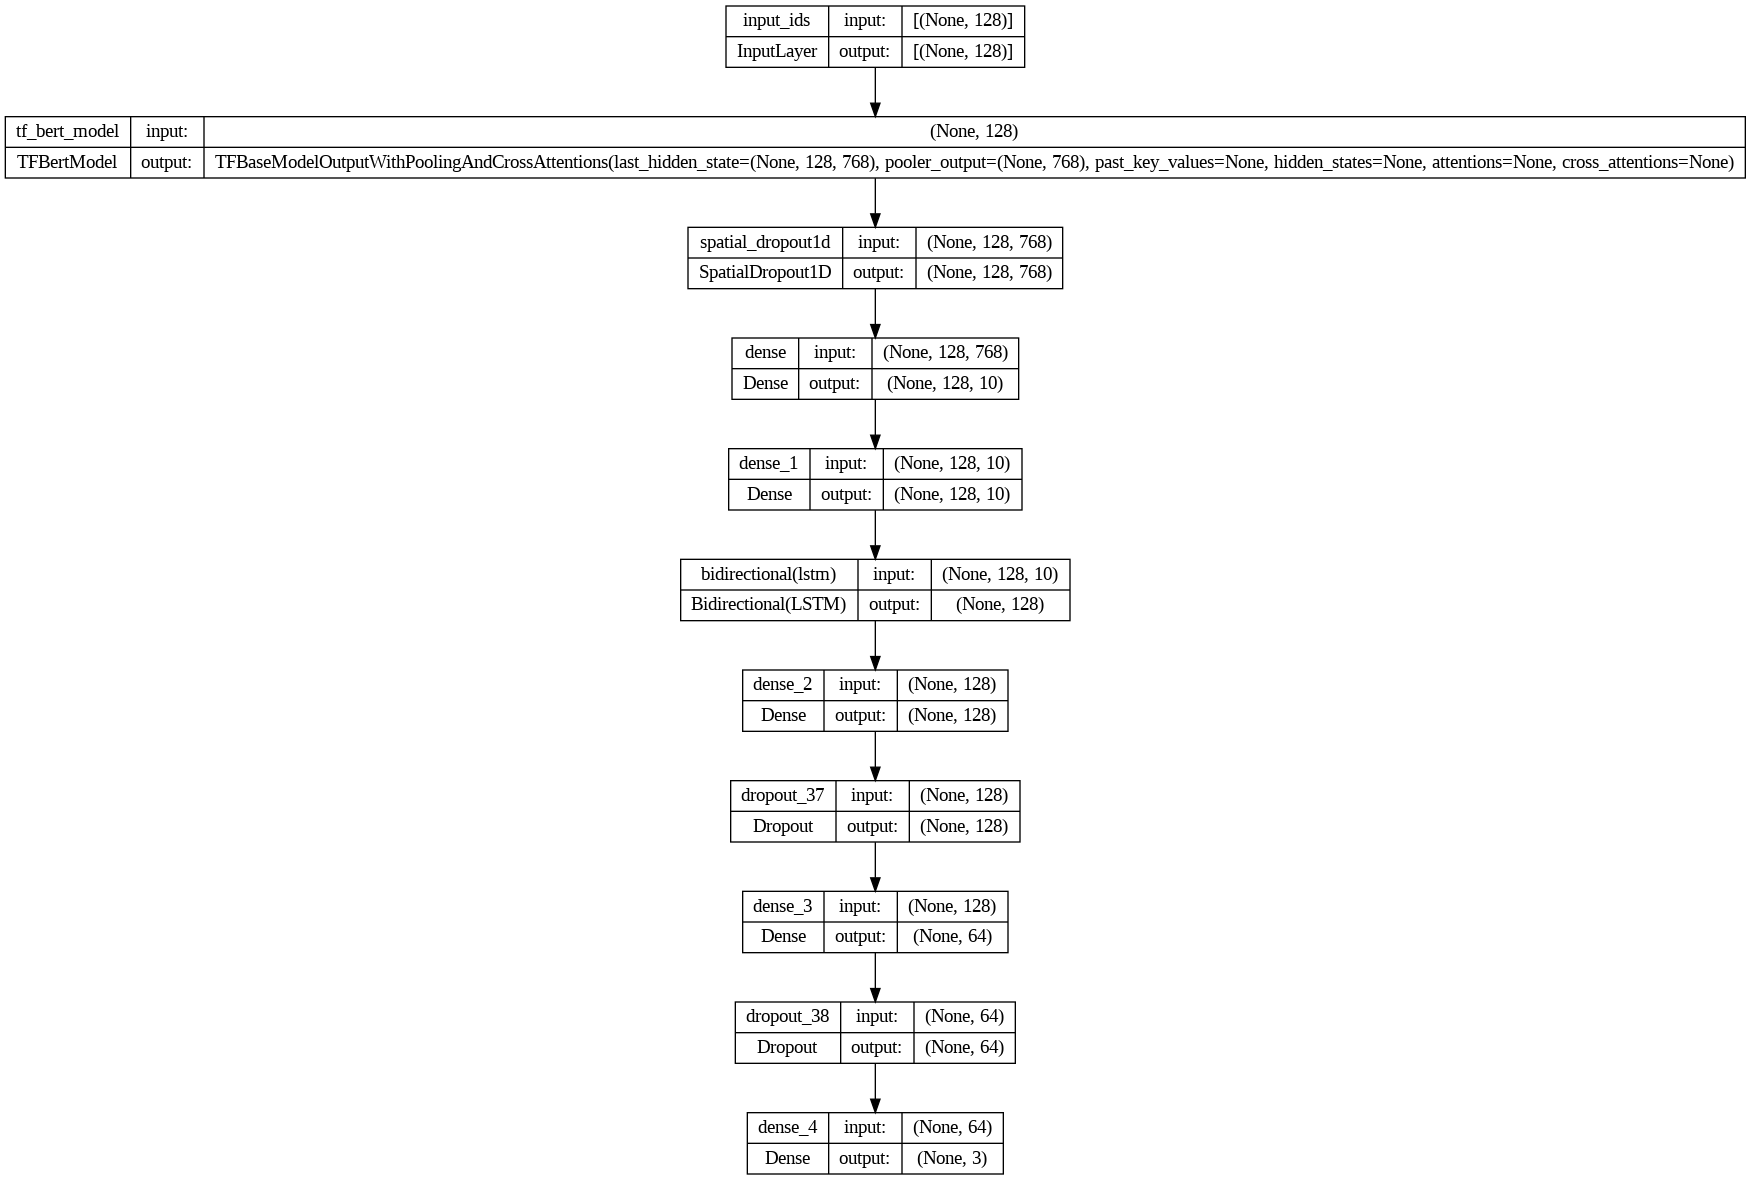

In [52]:
## model plotting
tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
#Model Training
seed(1)
random.set_seed(1)
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=10,
    validation_data=dev_dataset, verbose = 1)


Epoch 1/10


14/14 [==============================] - 191s 5s/step - loss: 0.9584 - accuracy: 0.6014 - val_loss: 0.8481 - val_accuracy: 0.6131
Epoch 2/10
14/14 [==============================] - 4s 279ms/step - loss: 0.8616 - accuracy: 0.6074 - val_loss: 0.8159 - val_accuracy: 0.6131
Epoch 3/10
14/14 [==============================] - 4s 261ms/step - loss: 0.8430 - accuracy: 0.5913 - val_loss: 0.7960 - val_accuracy: 0.6131
Epoch 4/10
14/14 [==============================] - 4s 260ms/step - loss: 0.8329 - accuracy: 0.6092 - val_loss: 0.7806 - val_accuracy: 0.6131
Epoch 5/10
14/14 [==============================] - 4s 300ms/step - loss: 0.8268 - accuracy: 0.6020 - val_loss: 0.7730 - val_accuracy: 0.6131
Epoch 6/10
14/14 [==============================] - 4s 265ms/step - loss: 0.8112 - accuracy: 0.5919 - val_loss: 0.7477 - val_accuracy: 0.6131
Epoch 7/10
14/14 [==============================] - 4s 261ms/step - loss: 0.7858 - accuracy: 0.6122 - val_loss: 0.7329 - val_accuracy: 0.6131
Epoch 8/10
14/14 [

In [54]:
## weight saving
model.save_weights('fakenewslabel.h5')

In [55]:
# Evaluation
test_encoded = bert_encode(test.text_without_stopwords)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

predicted_chats = model.predict(test_dataset, batch_size=batch_size)


4/4 [==============================] - 20s 3s/step


In [56]:
y_pred = []
for i in range(predicted_chats.shape[0]):
    y_pred.append(np.argmax(predicted_chats[i]))

In [57]:
## classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       270
           1       0.00      0.00      0.00       150

    accuracy                           0.64       420
   macro avg       0.32      0.50      0.39       420
weighted avg       0.41      0.64      0.50       420



In [58]:
## errors
meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
meanSqErr = metrics.mean_squared_error(y_test, y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)


Mean Absolute Error: 0.35714285714285715
Mean Square Error: 0.35714285714285715
Root Mean Square Error: 0.5976143046671968


In [59]:
## confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[270   0]
 [150   0]]


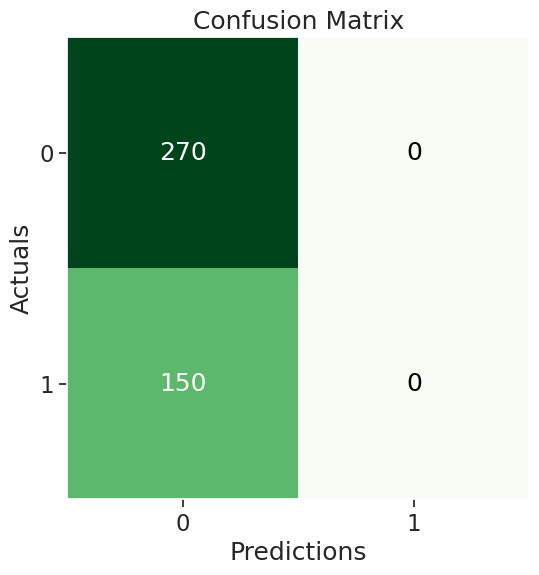

In [60]:
##plotting the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

**Prediction**

In [63]:
def decode_sentiment(score):
    if score == 0:
        return "Fake"
    else:
        return "Real"

In [ ]:
text = input("Please input your text or review: ")
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(np.argmax(score))

    return {"label": label, "score": score,
            "elapsed_time": time.time() - start_at}
predict(text)